In [1]:
import os
import time
import datetime
# from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup



##Exploration

In [2]:
from datasets import load_dataset
import torch
from tqdm import tqdm

wiki = load_dataset("wikitext", "wikitext-2-raw-v1")

In [3]:
train = wiki['train']['text']
test = wiki['test']['text']
val = wiki['validation']['text']

#Data preprocess

In [5]:
import re
def PreprocessTitle(dataset):
    filter_set = list(filter(lambda element: element != '', dataset))
    title_position = 0
    dealt_set = []
    title_content = ""
    for i,j in enumerate(filter_set):
        pattern_s = re.compile(r'@\W@')
        s_flag = pattern_s.search(j)
        if s_flag:
          filter_set[i] = re.sub(r' @(\W)@ ',r'\1',filter_set[i])
        pattern = re.compile(r'^ = .+ = \n$')
        result = pattern.match(j)
        if result:
            final_string = ""
            for k in range(title_position,i):
                if k == title_position:
                    pattern2 = re.compile(r'^ = = .+ = = \n$')
                    result2 = pattern2.match(filter_set[k])
                    if result2:
                        temp = re.sub(r' (\w)', f'{title_content}\\1', filter_set[k],count=1)
                        temp = re.sub(r'\n$', ':', temp)
                        # Remove =
                        # temp = re.sub(r' (\w)', f'{title_content}\\1', filter_set[k],count=1)
                        # temp = re.sub(r'\n$', '', temp)
                        # temp = " "+ temp.strip(' =')+ " "
                        # temp = temp + ": "
                    else:
                
                        temp = re.sub(r'\n$', ':', filter_set[k])
                        title_content = re.sub(r'^ = ', ' ', temp)
                        title_content = re.sub(r' = :$', ' : ', title_content)
                        # Remove =
                        # temp = re.sub(r'\n$', '', filter_set[k])
                        # temp = " "+ temp.strip(' =')+ " "
                        # temp = temp + ": "
                        # title_content = temp
                        # temp = re.sub(r': $', ':', temp)
                    final_string = final_string + temp
                else:
                    temp = re.sub(r'\n$', '', filter_set[k])  
                    final_string = final_string + temp
            pattern_empty = re.compile(r':$')
            flag = pattern_empty.search(final_string)
            if flag:
              pass
            else:
              dealt_set.append(final_string)
            title_position = i

    dealt_set = [s for s in dealt_set if s.strip() != ""] 
    return dealt_set

In [6]:
dealt_train = PreprocessTitle(train)
dealt_test = PreprocessTitle(test)
dealt_val = PreprocessTitle(val)
# for i in dealt_train[:25]:
#   print(i[:100])

In [7]:
from transformers import AutoTokenizer, BioGptForCausalLM

Parameters

In [8]:
batch_size = 1

In [9]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/biogpt", bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

In [10]:
# print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
# print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
# print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
# print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

In [11]:
class BioDataset(Dataset):

  def __init__(self, txt_list, tokenizer, max_length=200):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [12]:
train_dataset = BioDataset(dealt_train, tokenizer, max_length=500)
test_dataset = BioDataset(dealt_test, tokenizer, max_length=500)
val_dataset = BioDataset(dealt_val, tokenizer, max_length=500)

In [13]:
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [14]:
model = BioGptForCausalLM.from_pretrained("microsoft/biogpt")
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda")
model.cuda()

BioGptForCausalLM(
  (biogpt): BioGptModel(
    (embed_tokens): Embedding(42387, 1024)
    (embed_positions): BioGptLearnedPositionalEmbedding(1026, 1024)
    (layers): ModuleList(
      (0-23): 24 x BioGptDecoderLayer(
        (self_attn): BioGptAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (activation_fn): GELUActivation()
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affi

In [15]:
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [16]:
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

c:\Users\xiao\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [18]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [19]:
print(len(train_dataloader))

5514


In [20]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in tqdm(enumerate(train_dataloader)):
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


5514it [23:41,  3.88it/s]



  Average training loss: 3.28
  Training epoch took: 0:23:41

Running Validation...
  Validation Loss: 3.25
  Validation took: 0:00:33

======== Epoch 2 / 5 ========
Training...


5514it [23:52,  3.85it/s]



  Average training loss: 2.76
  Training epoch took: 0:23:52

Running Validation...
  Validation Loss: 3.01
  Validation took: 0:00:32

======== Epoch 3 / 5 ========
Training...


5514it [23:07,  3.97it/s]



  Average training loss: 2.28
  Training epoch took: 0:23:08

Running Validation...
  Validation Loss: 2.94
  Validation took: 0:00:34

======== Epoch 4 / 5 ========
Training...


5514it [23:46,  3.87it/s]



  Average training loss: 1.71
  Training epoch took: 0:23:46

Running Validation...
  Validation Loss: 3.09
  Validation took: 0:00:32

======== Epoch 5 / 5 ========
Training...


5514it [23:50,  3.85it/s]



  Average training loss: 1.06
  Training epoch took: 0:23:50

Running Validation...
  Validation Loss: 3.57
  Validation took: 0:00:33

Training complete!
Total training took 2:01:02 (h:mm:ss)


Let's view the summary of the training process.

In [21]:
# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,3.28,3.25,0:23:41,0:00:33
2,2.76,3.01,0:23:52,0:00:32
3,2.28,2.94,0:23:08,0:00:34
4,1.71,3.09,0:23:46,0:00:32
5,1.06,3.57,0:23:50,0:00:33


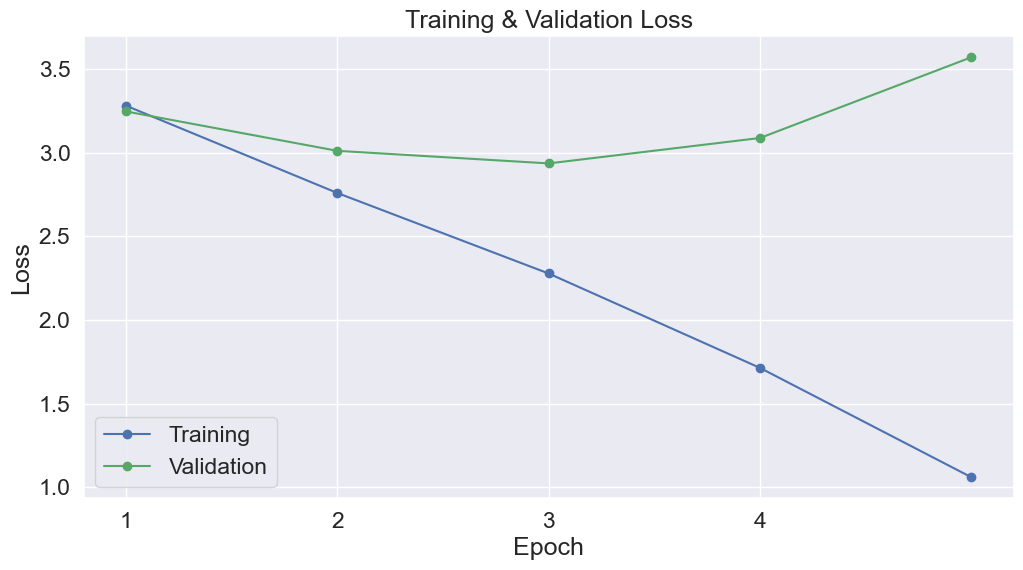

In [22]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [23]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The model has 388 different named parameters.

==== Embedding Layer ====

biogpt.embed_tokens.weight                              (42387, 1024)
biogpt.embed_positions.weight                           (1026, 1024)

==== First Transformer ====

biogpt.layers.0.self_attn.k_proj.weight                 (1024, 1024)
biogpt.layers.0.self_attn.k_proj.bias                        (1024,)
biogpt.layers.0.self_attn.v_proj.weight                 (1024, 1024)
biogpt.layers.0.self_attn.v_proj.bias                        (1024,)
biogpt.layers.0.self_attn.q_proj.weight                 (1024, 1024)
biogpt.layers.0.self_attn.q_proj.bias                        (1024,)
biogpt.layers.0.self_attn.out_proj.weight               (1024, 1024)
biogpt.layers.0.self_attn.out_proj.bias                      (1024,)
biogpt.layers.0.self_attn_layer_norm.weight                  (1024,)
biogpt.layers.0.self_attn_layer_norm.bias                    (1024,)
biogpt.layers.0.fc1.weight                              (4096, 1024

# Save Fine-Tuned Model


In [24]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save_Bio/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)



Saving model to ./model_save_Bio/


('./model_save_Bio/tokenizer_config.json',
 './model_save_Bio/special_tokens_map.json',
 './model_save_Bio/vocab.json',
 './model_save_Bio/merges.txt',
 './model_save_Bio/added_tokens.json')

# Generate Text

In [28]:
model.eval()

prompt = "<|startoftext|> = Soap = :"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                do_sample=True,
                                top_k=1000,
                                max_length = 1000,
                                top_p=2,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

tensor([[    2, 42384,    43, 10583,  8081,    43,    20]], device='cuda:0')
0: = Soap =: In the media, the Soap is a commercial enterprise in the United States. When viewed by figures from real-world affairs, the company was marketed as an immense commercial enterprise. The company continued in this enterprise until 2002, when it was recognized as the nation's main executive power and commentator of the National Economy. Using sliced splinter cut, the company penetrated and joined the development of railway hotels. Soap operatives later adapted the idea of the term Spc to avoid similar problems. In one version of the film, the producers made more than 18% of the production budget of traditional gender-owned hotels, up to 17%, the same year that its predecessor, Will Afanasieff, was entirely young, and compared the film with overall rigged ownership and office to more revenue, was more polished. In 2008, the production team attempted to achieve a youthful view of proposed targets, redu

PPL

In [26]:
max_length = model.config.max_position_embeddings
stride = 512

def ppl(model, input_ids_all, stride):
  nlls = []
  for i in tqdm(range(0, input_ids_all.size(1), stride)):
      begin_loc = max(i + stride - max_length, 0)
      end_loc = min(i + stride, input_ids_all.size(1))
      trg_len = end_loc - i  # may be different from stride on last loop
      input_ids = input_ids_all[:, begin_loc:end_loc].to("cuda:0")
      target_ids = input_ids.clone()
      target_ids[:, :-trg_len] = -100

      with torch.no_grad():
          outputs = model(input_ids, labels=target_ids)
          neg_log_likelihood = outputs[0] * trg_len

      nlls.append(neg_log_likelihood)

  ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
  return ppl

In [27]:
encodings = tokenizer("\n\n".join(dealt_test), return_tensors="pt")
ppl(model, encodings.input_ids, stride)

Token indices sequence length is longer than the specified maximum sequence length for this model (310653 > 1024). Running this sequence through the model will result in indexing errors
100%|██████████| 607/607 [01:22<00:00,  7.39it/s]


tensor(451.4723, device='cuda:0')